In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


%matplotlib inline

In [7]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

In [8]:
train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

In [9]:
train_df.sample(5).transpose()

rental_id,7340374,7179349,7259083,7351186,7339135
addr_unit,#4B,#5E,#4T,#17A,#PH2X
building_id,61234,47542,236914,77266,301
bedrooms,1,0,2,2,2
bathrooms,1,1,1,2,2
size_sqft,832,500,950,1400,1200
created_at,2018-07-06 17:03:50,2018-05-15 14:35:58,2018-06-10 19:48:37,2018-07-10 15:00:52,2018-07-06 14:00:46
addr_street,21 WEST 86 STREET,213 EAST 25 STREET,1357 PACIFIC STREET,242 EAST 72 STREET,21 SOUTH END AVENUE
addr_city,New York,New York,Brooklyn,New York,New York
addr_zip,10024,10010,11216,10021,10280
addr_lat,40.786,40.74,40.6777,40.7688,40.7083


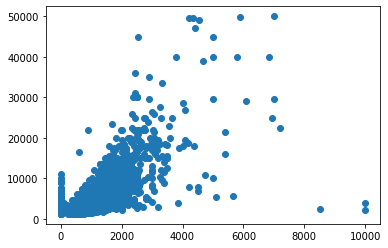

In [10]:
plt.scatter(train_df['size_sqft'],train_df['rent'])

In [11]:
#Had to remove features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
#Might have to try turning them into numbers to find out how important they are
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'has_garden', 'has_childrens_playroom', 'no_fee', 'rent']

#Most important features (comment it out to test every feature)
features = ['size_sqft', 'bbl', 'bathrooms', 'rent']

print('Train NaNs:', train_df[features].isna().sum(), sep='\n')
print('\n')
print('Test NaNs:', test_df[features].isna().sum(), sep='\n')

train_features = train_df[features].dropna()
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

Train NaNs:
size_sqft    0
bbl          0
bathrooms    0
rent         0
dtype: int64


Test NaNs:
size_sqft    0
bbl          0
bathrooms    0
rent         0
dtype: int64


In [12]:
lr = LinearRegression()
lr.fit(train_features, train_target)
test_pred = lr.predict(test_features)
cv_results = cross_val_score(lr, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('LinearRegression', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

dt = DecisionTreeRegressor()
dt.fit(train_features, train_target)
test_pred = dt.predict(test_features)
cv_results = cross_val_score(dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

gb = GradientBoostingRegressor()
gb.fit(train_features, train_target)
test_pred = gb.predict(test_features)
cv_results = cross_val_score(gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('GradientBoostingRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

rf = RandomForestRegressor()
rf.fit(train_features, train_target)
test_pred = rf.predict(test_features)
cv_results = cross_val_score(rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('RandomForestRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

#To get the feature importances for linear regression scale the features and then use .coef_
#importances for lr are in magnitude while others are in percentage
#I haven't scaled the features so this code doesn't really tell you much
importances = lr.coef_
print('\nLinear Regression:')
for i in range(len(importances)):
    print('\n',features[i], importances[i])
    
importances = dt.feature_importances_
print('\nDecision Tree:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
importances = gb.feature_importances_
print('\nGradient Boosting:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
importances = rf.feature_importances_
print('\nRandom Forest:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
#GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

LinearRegression 3586336.3066365756 [-4245428.15010456 -3455396.29845152 -3487234.67072484 -3946021.59294055
 -2216641.46957342] -3470144.4363589794
DecisionTreeRegressor 2626661.995277335 [-2999536.28709169 -2234311.27292061 -2750165.28967777 -1775425.7307252
 -1826123.6022123 ] -2317112.4365255125
GradientBoostingRegressor 2034677.6221161052 [-1788122.98691221 -1460121.47622275 -1997802.92603659 -1471210.07506988
 -1017205.33090647] -1546892.5590295796


C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor 2017623.4918998494 [-1799727.43478545 -1659905.04930064 -2286059.90511444 -1395395.48393289
  -975294.21495615] -1623276.4176179133

Linear Regression:

 size_sqft 2.6297502245284425

 bbl -7.234851782891552e-07

 bathrooms 1629.8621888219993

Decision Tree:

 size_sqft 64.13322655947582

 bbl 26.426382612762733

 bathrooms 9.440390827761464

Gradient Boosting:

 size_sqft 61.10266502534677

 bbl 22.1077802113521

 bathrooms 16.789554763301123

Random Forest:

 size_sqft 58.25054699911371

 bbl 25.73046409568453

 bathrooms 16.018988905201766


In [13]:
def testHyperparameter(param_grid):
    results = {}
    hp_name = list(param_grid.keys())[0]
    hp_values = list(param_grid.values())[0]
    
    # Create decision tree model and tune hyperparameter using GridSearchCV
    decision_tree = DecisionTreeRegressor()
    dt_cv = GridSearchCV(dt, param_grid, cv=5)
    dt_cv.fit(train_features, train_target)
    results['best_param'] = dt_cv.best_params_
    results['best_score'] = dt_cv.best_score_
    
    # Grab mean test/train score of 5 splits
    mean_test = dt_cv.cv_results_['mean_test_score']
    mean_train = dt_cv.cv_results_['mean_train_score']

    # Plot mean test/train AUC score against hyperparameter values
    line1, = plt.plot(hp_values, mean_test, 'b', label='Test AUC')
    line2, = plt.plot(hp_values, mean_train, 'r', label='Train AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel(hp_name)
    plt.show()
    
    print(results)

In [14]:
# Tuning individual hyperparameters for decision tree regressor 
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    testHyperparameter(hyperparameter)


KeyError: 'mean_train_score'

In [ ]:
# Testing all 4 hyperparameters together to find the best combination
param_grid = {
              "min_samples_split": [10, 20, 40, 80, 160],
              "max_depth": [2, 6, 8, 10, 15, 20, 30, 40, 50],
              "min_samples_leaf": [20, 40, 100, 200, 400],
              "max_leaf_nodes": [5, 20, 100, 200, 500]
              }

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, param_grid, cv=5, n_iter = 1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

In [ ]:
# Results of predicting rent on test set using optimized decision tree
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

In [15]:
rf = RandomForestRegressor(random_state = 42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [18]:
#Random Search Training
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                              cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

rf_random.fit(train_features, train_target)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [19]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [24]:
optimized_rf =  rf_random.best_estimator_
test_pred = optimized_rf.predict(test_features)
cv_results = cross_val_score(rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

#Mean Square Error slightly decreases.

C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Squared Error:  1916129.7384027774
CV Results:  [-1732767.67066683 -1599123.99372354 -1777733.59406543 -1492142.34450239
  -984236.614672  ]
Mean CV Results:  -1517200.8435260376


C:\Users\Garland\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
